In [1]:
import optuna
import pandas as pd
import sys
import matplotlib.pyplot as plt
sys.path.append('/opt/ml/code/src/')

from utils import seed_everything, roc_auc_score
from model import xgboost
from features import feature_engineering

SEED = 42  # 랜덤 시드
seed_everything(SEED)  # 시드 고정

In [2]:
# 데이터 파일 읽기
data = pd.read_csv("/opt/ml/code/input/train.csv", parse_dates=["order_date"])

# 피처 엔지니어링 실행
train, test, y, features = feature_engineering(data, '2011-12')

categorical feature: ['year_month-mode']
train_set.shape (5722, 144) , test_set.shape (5914, 144)


In [3]:
def objective(trial):
    xgb_params = {
        'objective': 'binary:logistic', # 이진 분류
        'learning_rate': trial.suggest_float('learning_rate', 1e-6, 0.3, log=True), # 학습률
        'max_depth': trial.suggest_int("max_depth", 6, 10), # 트리 최고 깊이

        # 피처 샘플링 비율 , # 피처 샘플링 비율
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9), 
        'subsample': trial.suggest_float('subsample', 0.4, 0.9), # 데이터 샘플링 비율
        'eval_metric': 'auc', # 평가 지표 설정
        'seed': SEED,
    }
    
    # oof prediction 함수 호출해서 out of fold validation 예측값을 얻어옴
    y_oof, test_preds = xgboost(train, y, test, features, xgb_params, WANDB_USE=False)
    
    # Validation 스코어 계산
    val_auc = roc_auc_score(y, y_oof)
    
    return val_auc

In [4]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials = 100)

UC = 0.8207344545291171
Precision: 0.67747
Recall: 0.36953
F1 Score: 0.47821
ROC AUC Score: 0.82073
fold: 1, x_tr.shape: (5149, 141), x_val.shape: (573, 141)
[0]	train-auc:0.83632	valid-auc:0.77019
[200]	train-auc:0.98244	valid-auc:0.80315
[254]	train-auc:0.98427	valid-auc:0.80434
Fold 1 | AUC: 0.8043349498389665
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (5149, 141), x_val.shape: (573, 141)
[0]	train-auc:0.83647	valid-auc:0.76223
[200]	train-auc:0.98308	valid-auc:0.78790
[209]	train-auc:0.98350	valid-auc:0.78670
Fold 2 | AUC: 0.7866952948580314
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (5150, 141), x_val.shape: (572, 141)
[0]	train-auc:0.83267	valid-auc:0.79573
[138]	train-auc:0.97738	valid-auc:0.83159
Fold 3 | AUC: 0.8318524602404241
--------------------------------------------------------------------------------
fold: 4, x_tr.shape: (5150, 141), x_val.shape: (572, 1

In [5]:
study.best_value

0.8226296006677567

In [7]:
study.best_params

{'learning_rate': 0.02211903224420238,
 'max_depth': 6,
 'colsample_bytree': 0.7173762029018879,
 'subsample': 0.8450778548079342}

In [8]:
study.trials_dataframe()

,number,value,datetime_start,datetime_complete,duration,params_colsample_bytree,params_learning_rate,params_max_depth,params_subsample,state
0,0,0.791793,2021-04-21 22:17:10.446493,2021-04-21 22:17:50.949216,0 days 00:00:40.502723,0.771597,0.000375,8,0.716085,COMPLETE
1,1,0.811735,2021-04-21 22:17:50.950802,2021-04-21 22:18:49.391918,0 days 00:00:58.441116,0.847148,0.024895,9,0.816833,COMPLETE
2,2,0.802493,2021-04-21 22:18:49.393078,2021-04-21 22:19:39.271128,0 days 00:00:49.878050,0.631724,0.008727,8,0.593651,COMPLETE
3,3,0.776019,2021-04-21 22:19:39.272388,2021-04-21 22:20:21.753162,0 days 00:00:42.480774,0.544153,0.000997,9,0.495962,COMPLETE
4,4,0.798447,2021-04-21 22:20:21.754440,2021-04-21 22:21:22.286810,0 days 00:01:00.532370,0.867805,0.006530,6,0.691466,COMPLETE
...,...,...,...,...,...,...,...,...,...,...
95,95,0.817801,2021-04-21 23:25:44.769933,2021-04-21 23:26:15.334405,0 days 00:00:30.564472,0.647881,0.041415,6,0.762696,COMPLETE
96,96,0.818941,2021-04-21 23:26:15.335614,2021-04-21 23:26:48.322878,0 days 00:00:32.987264,0.633966,0.029543,6,0.795743,COMPLETE
97,97,0.820811,2021-04-21 23:26:48.324204,2021-04-21 23:27:31.909524,0 days 00:00:43.585320,0.625000,0.021148,6,0.770565,COMPLETE
98,98,0.819656,2021-04-21 23:27:31.910824,2021-04-21 23:28:17.385625,0 days 00:00:45.474801,0.617966,0.022106,6,0.741301,COMPLETE


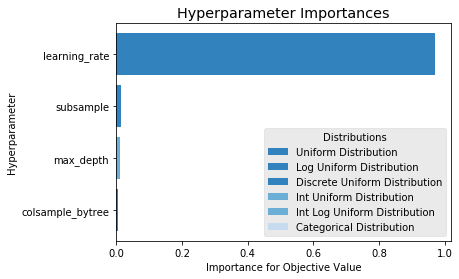

In [9]:
optuna.visualization.matplotlib.plot_param_importances(study)
plt.show()

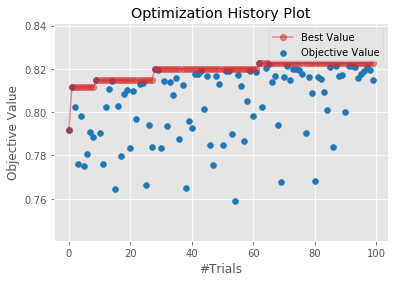

In [10]:
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.show()

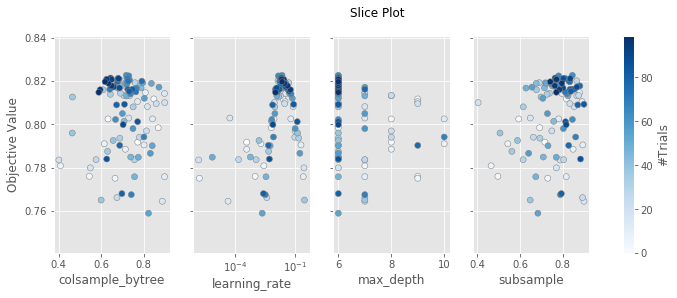

In [11]:
optuna.visualization.matplotlib.plot_slice(study)
plt.show()

[W 2021-04-22 04:22:32,772] Output figures of this Matplotlib-based `plot_contour` function would be different from those of the Plotly-based `plot_contour`.


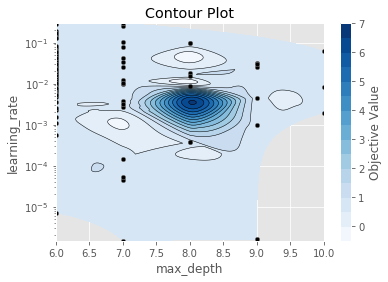

In [12]:
optuna.visualization.matplotlib.plot_contour(study, params=['max_depth','learning_rate'])
plt.show()

In [13]:
optuna.visualization.matplotlib.plot_parallel_coordinate(study, params=['max_depth','learning_rate'])
plt.show()

ValueError: Data has no positive values, and therefore can not be log-scaled.